# Pressure drag

In this final section we will develop a pressure drag model that can be applied to real engineering flows.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from vortexpanel import VortexPanel as vp
from vortexpanel import BoundaryLayer as bl

### Bernoulli equation

The first step is to compute the pressure, $P$, which we can get using the Bernoulli equation

$$ P+\frac 12 \rho\ |u|^2-\rho gz = B $$

where $\rho$ is the density, $\rho gz$ is the head, and $B$ is the Bernoulli coefficient. As in the rest of this course, will assume no hydrostatic pressure.

To avoid the ambiguity of the Bernoulli coefficient, we typically work with the pressure coefficient $c_p$

$$c_p = \frac{P-P_\infty}{\frac 12\rho\ U^2}$$
instead of the pressure.

##### Quiz

Which is a correct simplification of the pressure coefficient?

1. $c_p = \frac 12 |u|^2$
1. $c_p = 1-|u|^2/U^2$
1. $c_p = 1-P/P_\infty$

---
So lets use this to plot $c_p(s)$ on the surface of a circle in a uniform flow:

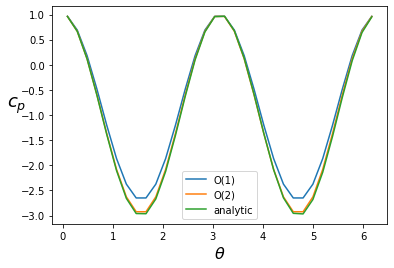

In [2]:
circle = vp.make_circle(N=32)  # set-up geom
s = circle.distance()

circle.solve_gamma()           # find gamma O(1)
plt.plot(s,1-circle.get_array('gamma')**2, label='O(1)')

circle.solve_gamma_O2()        # find gamma O(2)
plt.plot(s,1-circle.get_array('gamma')**2, label='O(2)')

plt.plot(s,1-4*np.sin(s)**2, label='analytic')
plt.xlabel(r'$\theta$', fontsize=16)
plt.ylabel(r'$c_p$', fontsize=18,rotation=0)
plt.legend();

Where we've use $|u/U|^2=\tilde\gamma^2=\gamma^2$ on the body (yet again), and threw in another comparison between the solvers for good measure. 


Notice the stagnation pressure coefficient is one by definition, and that $c_p$ is symmetric on the front and back of the body.

---

## Pressure force

Once we have the surface pressure we can use it to determine the pressure force on the body, as

$$ \vec F_p = -\oint p \hat n da $$

where $\oint da$ is the integral over the body surface, and $\hat n$ is the normal vector to the surface. 

For instance, the lift coefficient is then:

$$ C_L = \frac{\vec F_p \cdot \hat U_\perp} { \tfrac 12 \rho U^2 A }  = \frac{-\oint p \hat n \cdot \hat U_\perp ds }{ \tfrac 12 \rho U^2 c } c= -\frac{\oint c_p (s_x\cos\alpha+s_y\sin\alpha) ds}{ c } $$

where $c$ is the coord, $\hat U_\perp=\cos\alpha\hat y-\sin\alpha\hat x$ is the direction perpendicular to the free stream and $\hat n=s_x\hat y-s_y\hat x$ as seen in the figure below:

![short](resources/graphics6.png)

Let's test is on the Jukowski foil...

In [3]:
def C_L(panels,alpha):
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy')
    c = max(xc)-min(xc)
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)
    return -sum((1-gamma**2)*2*S*perp)/c

foil = vp.make_jfoil(N=32)
foil.solve_gamma_O2(alpha=0.1,kutta=[(0,-1)])
print("C_L = {:.3f}".format(C_L(foil,alpha=0.1)))

C_L = 0.733


This function will give the same result for the __total__ lift as the circulation-based formula from notebook 3_3. However, when simulating the flow on multiple bodies, only the formula above can be applied to find the lift on each body individually.


---

Similarly, the (pressure) drag coefficient $C_P$ is:

$$ C_P = \frac{\vec F_p \cdot \hat U_\parallel} { \tfrac 12 \rho U^2 A } = \frac{\oint c_p (s_y\cos\alpha-s_x\sin\alpha) ds}{ t } $$

where $t$ is the thickness and $\hat U_\parallel$ is the direction parallel to $\vec U$. Let's test $C_P$ on the circle flow with $\alpha=0$.

In [4]:
def C_P(panels):
    gamma,yc,sy,S = panels.get_array('gamma', 'yc', 'sy', 'S')
    t = max(yc)-min(yc)
    return sum((1-gamma**2)*sy*2*S)/t

print("C_P = {:.16f}".format(C_P(circle)))

C_P = -0.0000000000000010


##### Quiz

Why is the pressure drag equal to zero?

1. The symmetric shape of the circle
1. Potential flow
1. Insufficient resolution
---



## Wake model

We can predict the forces in terms of the vortex sheets instead of the pressure, but we need a wake to produce drag.

Lets assume the boundary layers separate from the body into a pair of **shear layers**, but maintain the same strength ($\gamma$) as they were at the point of separation. We'll also assume that the distance between the shear layers ($w$) stays the same.

![short](resources/shear_wake.png)

The shear layers induce a change in momentum due to the continual growth of the vortex sheets in time:

$$ D = \rho \frac{d}{dt}\int_S y \gamma ds $$

Note: the real wake doesn't look like this. But these assumptions might be good enough to determine how the drag __scales__.

---

##### Quiz

How does the drag induced by the shear layers in the sketch scale?

1. $\rho U^2 t$
1. $\rho \gamma^2 w$
1. $\rho U^2 \gamma $

---

Let's do a quick sanity check on this model to make sure we're happy with it:
- The wider the wake, the greater the drag
- The stronger the shear layers, the greater the drag
- __Critically__ we can compute these values ($\gamma$,$w$) using numerical boundary layer decomposition

This is promising, but...

##### Numerical fundamental: Validation 
##### Every piece of code must be tested against a known nontrivial example (last time, promise) 

---

## Wake coefficient calibration

To test (and potentialy calibrate) our simple wake deficit model against this data we first define a wake momentum coefficient 
$$C_\gamma = \frac {\rho \gamma^2 w}{\rho U^2 t} = \frac w t \tilde\gamma ^2$$
Note that I've scaled the wake deficit estimate by $\rho U^2 t$ so that we can compare it to $C_P$.

Then `for` each $c/t$:
1. `Solve` the flow, `split` the body, and use `thwaites` for the boundary layer. (We have already validated this step.)
1. Measure the predicted $w$ and $\gamma$ __at the separation point__ to determine $C_\gamma$.
1. Finally, plot $C_\gamma$ against the experimental $C_D$ from Hoerner, giving:

![small](resources/pressure_drag.png)

Despite simplicity of our wake model, the wake coefficient is almost perfectly correlated with the pressure drag! The equation for the line above is:

$$ C_P = 0.343 C_\gamma$$

---

##### Quiz

What do you think would be the fastest way to estimate forces in the early stages of the design process?

1. Analytic potential flow theory
1. Numerical boundary layer decomposition
1. Navier-Stokes simulations (CFD)
2. Experiments

---

##### Your turn

 - **Complete** the function `C_gamma` to determine the wake coefficient following the method described above.
 - **Plot and Compare ** your predictions to Hoerner's reported $C_D$ data.

In [5]:
def C_gamma(panels):
    return # your code here

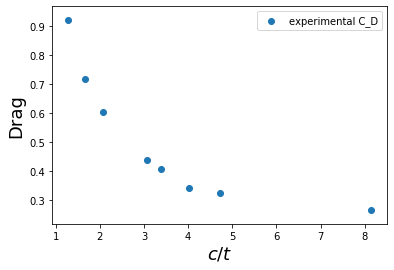

In [6]:
# Hoerner's data
c_t = [1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15]
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]
plt.scatter(c_t,CD,label='experimental C_D')

# your code here

plt.legend()
plt.xlabel(r'$c/t$', fontsize=18)
plt.ylabel(r'Drag', fontsize=18);